In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [5]:
col = ["Service_ID",'Patient_ID','Patient_Number','IMREDEM_CODE',
       'patient_age','Actual_Dr_Name','Place_of_Service_Abbr','Proc_Category_Abbr',
       'Type_of_Service_Abbr','patient_zip_code','patient_sex','Original_Carrier_Name','Patient_City',
       'Patient_State','Diagnosis_Code','Diagnosis_Descr','CoPayment','CoInsurance',
       'Primary_Diagnosis_Code','Procedure_Code','Service_Units','Service_Date_From','Claim_Number', 
       'Original_Billing_Date', 'Date_Paid','Service_Fee','Amount', 'Allowed', 'Deductible',
       'Transaction_Type','Abbreviation' ,'Description', 'Self_Pay_TranCode']


In [6]:
df = pd.read_csv(r'E:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/New folder/ML_data.csv', header = None, names = col)
df.shape

(218041, 33)

In [7]:
df["Description"] = df["Description"].apply(lambda x: -999 if str(x).startswith("Self") else x)
self_pay_index = df.loc[df["Description"] == -999].index
df = df.drop(self_pay_index)

In [8]:
list_of_col_drop = ["Self Pay Transfer", "Self Pay Adjustment", "Self Pay Financial Hardship"]
df = df[~df.Description.isin(list_of_col_drop)]
df = df.drop(["IMREDEM_CODE", "Patient_ID"], axis=1)

In [9]:
# Preprocessing   CTRL+/ to comment multiple statements
df = df.loc[df["Service_Date_From"] >= "2017-01-01"]
print(df.shape)
df = df.drop_duplicates() 
print(df.shape)
df = df.loc[df["Service_Fee"] > 0]
print(df.shape)
df = df.loc[df["Original_Billing_Date"].notna()]
df = df.loc[df["Date_Paid"].notna()]
index_names = df[(df['Transaction_Type'] == 'T') & (df['Amount']> 0)].index
df.drop(index_names, inplace = True)

(211290, 31)
(188799, 31)
(133006, 31)


In [10]:
# Target variable derviation
df["Original_Billing_Date"] = pd.to_datetime(df["Original_Billing_Date"])
df["Date_Paid"] = pd.to_datetime(df["Date_Paid"])
df["Delay_in_days"] = pd.to_datetime(df["Date_Paid"]) - pd.to_datetime(df["Original_Billing_Date"])
df["Delay_in_days"] = df["Delay_in_days"].apply(lambda x : int(str(x).split(" ")[0]))
df["Payment_portion"] = df["Amount"] / df["Service_Fee"]
df["Decay"] = (1 - (df["Delay_in_days"] / 365))
df["Actual_decay"] = df["Decay"].apply(lambda x : max(0, x))
df["Score"] = df["Actual_decay"] * df["Payment_portion"]

In [11]:
# If the payment is -ve trasaction need to remove those records for that index is taken for last 
#negative transaction and kept and greater index that one
patient_id = df["Patient_Number"].value_counts().keys().tolist()
new_df = pd.DataFrame()
for i in range(len(patient_id)): 
    service_id = df.loc[df["Patient_Number"] == patient_id[i]]
#     new_df = new_df.append(service_id)
    service = service_id.loc[service_id["Score"] < 0].empty

    if service == False:
        index_to_consider_to_drop = service_id.loc[service_id["Score"] < 0].index.tolist()[-1]
        service_id = service_id[service_id.index > index_to_consider_to_drop]
        new_df = new_df.append(service_id)

    else:
        new_df = new_df.append(service_id)
        
# index to drop this will afftect the target score drop the records where payment proportion is 1
# index_to_drop = new_df.loc[new_df["Payment_portion"] == 1.0].index[0]
# new_df = new_df.drop(index_to_drop, axis=0)

# Drop the records where delay in days is coming -ve. because original billing date is coming greater thatn
# date paid column
# new_df = new_df.loc[new_df["Delay_in_days"] >= 0]


# copy the data drame
new_df_copy = new_df

In [12]:
new_df_copy = new_df

In [13]:
new_df_copy.shape

(100364, 36)

In [14]:
# calculationsof weights for the target variable
# def weights(score):
    
#     weight = None
    
#     if score > 0.9 and score <=1.0:
#         weight = 1
        
#     if score > 0.8 and score <= 0.9:
#         weight = 0.9
    
#     if score > 0.7 and score <= 0.8:
#         weight = 0.8
        
#     if score > 0.6 and score <= 0.7:
#         weight = 0.7
        
#     if score > 0.5 and score <= 0.6:
#         weight = 0.6
        
#     if score > 0.4 and score <= 0.5:
#         weight = 0.5
        
#     if score > 0.3 and score <= 0.4:
#         weight = 0.4
        
#     if score > 0.2 and score <= 0.3:
#         weight = 0.3
        
#     if score > 0.1 and score <= 0.2:
#         weight = 0.2
        
#     if score >= 0 and score <= 0.1:
#         weight = 0.1
        
#     return weight
        
# # on the copied data frame weights are applied
# new_df_copy["Weights"] = new_df_copy["Score"].apply(weights)
# # remove the weights where there are null value
# new_df_copy = new_df_copy[~new_df_copy["Weights"].isna()]
# # get the score where score is greated than 0 so that weight_acore will not affect
# new_df_copy = new_df_copy.loc[new_df["Score"] > 0]

In [15]:
# Create a group data and target variable as mean
x = new_df_copy.groupby(["Service_ID"], as_index=False).agg({
    

    "Patient_Number" : "first",
    'patient_age': "max",
    'Actual_Dr_Name':'first',
    'Place_of_Service_Abbr':'first',
    'Proc_Category_Abbr':'first',
    'Type_of_Service_Abbr':'first',
    'patient_zip_code': "first",
    'patient_sex' : "first",
    'Original_Carrier_Name':"first",
    'Patient_City':"first",
    'Patient_State':"first",
    "Diagnosis_Code" : 'first',
    "Diagnosis_Descr":"first",
    'CoInsurance':"sum", 
    'CoPayment':"sum", 
    "Primary_Diagnosis_Code" : "first",
    "Procedure_Code":"first",
    'Service_Units':"sum",
    'Service_Date_From':"first",
    "Claim_Number" : "first",
    "Original_Billing_Date":"first",
    "Date_Paid":'last',
    "Service_Fee":"max",
    "Amount":"max",
    'Allowed': 'max',
    "Deductible":"max",
    "Transaction_Type":"count",
    "Score": "sum"
})

<AxesSubplot:xlabel='Score', ylabel='Density'>

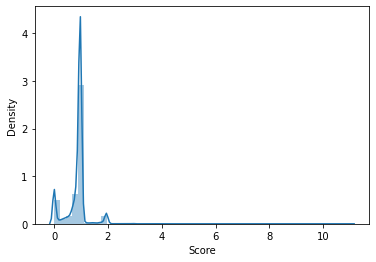

In [18]:
import seaborn as sns
sns.distplot(x["Score"])

In [20]:
# Create a weight_Score new dataframe
# weihted_score = new_df_copy.groupby("Service_ID", as_index=False).apply(lambda x: np.average(x['Score'], weights=x['Weights']))
# weihted_score = pd.DataFrame(weihted_score)
# weihted_score["Weighted_Score"] = weihted_score.iloc[:,1]
# weihted_score = weihted_score[["Service_ID", "Weighted_Score"]]
# Combine a dataframe to new dataframe
# new_df_copy = pd.merge(x, weihted_score, on='Service_ID')


In [21]:
# Aggregate again for the combination
x = x.groupby(["Patient_Number", "Original_Carrier_Name","Primary_Diagnosis_Code","Procedure_Code"], as_index=False).agg({
    
    "Service_ID" : "count",
#     "Patient_Number" : "first",
    'patient_age': "max",
    'Actual_Dr_Name':'first',
    'Place_of_Service_Abbr':'first',
    'Proc_Category_Abbr':'first',
    'Type_of_Service_Abbr':'first',
    'patient_zip_code': "first",
    'patient_sex' : "first",
#     'Original_Carrier_Name':"first",
    'Patient_City':"first",
    'Patient_State':"first",
    "Diagnosis_Code" : 'first',
    "Diagnosis_Descr":"first",
    'CoInsurance':"sum", 
    'CoPayment':"sum", 
#     "Primary_Diagnosis_Code" : "first",
#     "Procedure_Code":"first",
    'Service_Units':"sum",
    'Service_Date_From':"first",
    "Claim_Number" : "first",
    "Original_Billing_Date":"first",
    "Date_Paid":'last',
    "Service_Fee":"max",
    "Amount":"max",
    'Allowed': 'max',
    "Deductible":"max",
    "Transaction_Type":"count",
    "Score": "sum"
})



<AxesSubplot:xlabel='Score', ylabel='Density'>

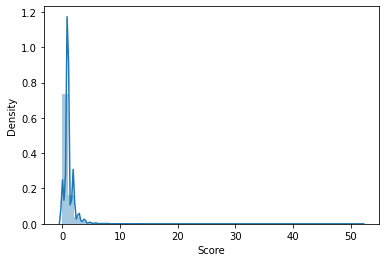

In [22]:
import seaborn as sns
sns.distplot(x["Score"])

In [23]:
x['Score']

0        3.145205
1        3.901370
2        1.956164
3        0.956164
4        0.956164
           ...   
21045    0.983562
21046    0.834537
21047    0.000000
21048    0.983562
21049    0.983562
Name: Score, Length: 21050, dtype: float64

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
x = x[x["Score"] < 12]
# x = x.drop_duplicates()

In [29]:
x.shape

(21024, 29)

In [30]:
col_names = ['Score']
features = x[col_names]
scaler = MinMaxScaler(feature_range=(0,1))
x[col_names] = scaler.fit_transform(features.values)
x.shape

(21024, 29)

In [33]:
x[col_names]

,Score
0,0.262700
1,0.325858
2,0.163387
3,0.079863
4,0.079863
...,...
21045,0.082151
21046,0.069704
21047,0.000000
21048,0.082151


<AxesSubplot:xlabel='Score', ylabel='Density'>

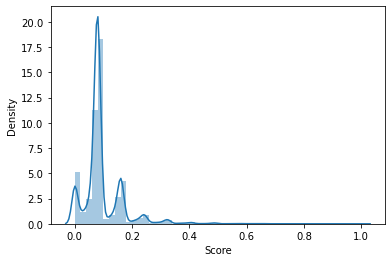

In [21]:
sns.distplot(x["Score"])

In [22]:
x.columns

Index(['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code',
       'Procedure_Code', 'Service_ID', 'patient_age', 'Actual_Dr_Name',
       'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr',
       'patient_zip_code', 'patient_sex', 'Patient_City', 'Patient_State',
       'Diagnosis_Code', 'Diagnosis_Descr', 'CoInsurance', 'CoPayment',
       'Service_Units', 'Service_Date_From', 'Claim_Number',
       'Original_Billing_Date', 'Date_Paid', 'Service_Fee', 'Amount',
       'Allowed', 'Deductible', 'Transaction_Type', 'Score'],
      dtype='object')

In [34]:
x = x.drop("Service_ID", axis=1)
x = x.drop_duplicates()
x["Diagnosis_Code"] = x["Diagnosis_Code"].astype('category')
x["Patient_Number"] = x["Patient_Number"].astype('category')
x["patient_age"] = x["patient_age"].astype('int64')
x["Actual_Dr_Name"] = x["Actual_Dr_Name"].astype('category')
x["Place_of_Service_Abbr"] = x["Place_of_Service_Abbr"].astype('category')
x["Proc_Category_Abbr"] = x["Proc_Category_Abbr"].astype('category')
x["Type_of_Service_Abbr"] = x["Type_of_Service_Abbr"].astype('category')
x["patient_zip_code"] = x["patient_zip_code"].astype('category')
x["patient_sex"] = x["patient_sex"].astype('category')
x["Original_Carrier_Name"] = x["Original_Carrier_Name"].astype('category')
x["Patient_City"] = x["Patient_City"].astype('category')
x["Patient_State"] = x["Patient_State"].astype('category')
x["Diagnosis_Descr"] = x["Diagnosis_Descr"].astype('category')
x["CoInsurance"] = x["CoInsurance"].astype('int64')
x["CoPayment"] = x["CoPayment"].astype('int64')
x["Primary_Diagnosis_Code"] = x["Primary_Diagnosis_Code"].astype('category')
x["Procedure_Code"] = x["Procedure_Code"].astype('category')
x["Service_Units"] = x["Service_Units"].astype("int64")
x["Service_Date_From"] = pd.to_datetime(x["Service_Date_From"])
x["Claim_Number"] = x["Claim_Number"].astype('category')
x["Original_Billing_Date"] = pd.to_datetime(x["Original_Billing_Date"])
x["Date_Paid"] = pd.to_datetime(x["Date_Paid"])
x["Claim_Number"] = x["Claim_Number"].astype('category')

x["Allowed"] = x["Allowed"].fillna(0)
x["Payment_portion_percentage"]= x["Allowed"] / x["Service_Fee"] * 100
x["Score"] = np.round(x["Score"], 2)

In [35]:
x.shape

(21024, 29)

In [36]:
x.isna().sum()

Patient_Number                    0
Original_Carrier_Name             0
Primary_Diagnosis_Code            0
Procedure_Code                    0
patient_age                       0
Actual_Dr_Name                    0
Place_of_Service_Abbr             0
Proc_Category_Abbr                0
Type_of_Service_Abbr              0
patient_zip_code                  0
patient_sex                       0
Patient_City                      0
Patient_State                     0
Diagnosis_Code                    0
Diagnosis_Descr                   0
CoInsurance                       0
CoPayment                         0
Service_Units                     0
Service_Date_From                 0
Claim_Number                      0
Original_Billing_Date             0
Date_Paid                         0
Service_Fee                       0
Amount                            0
Allowed                           0
Deductible                    19855
Transaction_Type                  0
Score                       

In [38]:
# x["Allowed"] = x["Allowed"].fillna(0)
x["Payment_portion_percentage"] = x["Payment_portion_percentage"].fillna(0)
x = x.drop(["Deductible"], axis=1)
from sklearn.impute import SimpleImputer
impute = SimpleImputer(strategy='most_frequent')
x["Original_Carrier_Name"] = impute.fit_transform(x[["Original_Carrier_Name"]])
x.isna().sum() 

Patient_Number                0
Original_Carrier_Name         0
Primary_Diagnosis_Code        0
Procedure_Code                0
patient_age                   0
Actual_Dr_Name                0
Place_of_Service_Abbr         0
Proc_Category_Abbr            0
Type_of_Service_Abbr          0
patient_zip_code              0
patient_sex                   0
Patient_City                  0
Patient_State                 0
Diagnosis_Code                0
Diagnosis_Descr               0
CoInsurance                   0
CoPayment                     0
Service_Units                 0
Service_Date_From             0
Claim_Number                  0
Original_Billing_Date         0
Date_Paid                     0
Service_Fee                   0
Amount                        0
Allowed                       0
Transaction_Type              0
Score                         0
Payment_portion_percentage    0
dtype: int64

In [40]:
#import catboost as cb
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, accuracy_score
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import plotly
from plotly.offline import iplot
import plotly.graph_objs as go     

import datetime

# Importing libraries for feature selection by varianceThresholdmethod and chi2_contingency
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency
import statsmodels.api as sm

#Train test split
from sklearn.model_selection import train_test_split
# imputing for missing values
from sklearn.impute import SimpleImputer
# Standerdisation of numeric attributes and dummification of cat features
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ModuleNotFoundError: No module named 'catboost'

In [ ]:
# x = x.drop("Service_ID", axis=1)
x.drop_duplicates()

In [ ]:
y = x["Score"]
X = x.drop("Score", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [ ]:
#List of categorical columns
categoricalcolumns = X_train.select_dtypes(include=["category", "object"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
#Get location of categorical columns
cat_features = [X_train.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ",cat_features)
cat_features = [int(i) for i in cat_features]

In [ ]:
# importing Pool
from catboost import Pool
#Creating pool object for train dataset. we give information of categorical fetures to parameter cat_fetaures
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )
#Creating pool object for test dataset
test_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features
                 )

In [ ]:
#build model
cat_model = CatBoostRegressor(loss_function='RMSE')
# Fit model 
cat_model.fit(train_data)

In [ ]:
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)
def model_score(y_train, y_train_pred, y_test, y_test_pred):
    print("Training performance")
    mean_sq_error = mean_squared_error(y_train, y_train_pred)
    print("Mean squared error {:.2f}".format(mean_sq_error))
    rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print('RMSE: {:.2f}'.format(rmse))
    r2_score_ = r2_score(y_train,y_train_pred)
    print('r2_score is : {:.2f}'.format(r2_score_))
#     mean_absolute_error_ = mean_absolute_error(y_train, y_train_pred)
#     print('mean_absolute_error is : {:.2f}'.format(mean_absolute_error_))
# #     mean_absolute_percentage_error_ = mean_absolute_percentage_error(y_train, y_train_pred)
#     adjusted_r_square = r2AndAdjustedr2(y_train, y_train_pred)
#     print("Adjusted r square is : {:.2f}".format(adjusted_r_square))
    
    print("************************")
    print("Testing performance")
    mean_sq_error = mean_squared_error(y_test, y_test_pred)
    print("Mean squared error {:.2f}".format(mean_sq_error))
    rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
    print('RMSE: {:.2f}'.format(rmse))
    r2_score_ = r2_score(y_test,y_test_pred)
    print('r2_score is : {:.2f}'.format(r2_score_))
#     mean_absolute_error_ = mean_absolute_error(y_test, y_test_pred)
#     print('mean_absolute_error is : {:.2f}'.format(mean_absolute_error_))
# #     mean_absolute_percentage_error_ = mean_absolute_percentage_error(y_test, y_test_pred)
#     adjusted_r_square = r2AndAdjustedr2(y_test, y_test_pred)
#     print("Adjusted r square is : {:.2f}".format(adjusted_r_square))
    
    
    return


print(model_score(y_train, y_train_pred, y_test, y_test_pred))

In [ ]:
sorted_feature_importance = cat_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        cat_model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [ ]:
y_train = y_train.reset_index(drop=True)
y_train_pred = pd.Series(y_train_pred, name="Predicted_train_score").reset_index(drop = True)
prediction_on_train_data = pd.concat([y_train, y_train_pred], axis=1)
y_test = y_test.reset_index(drop=True)
y_test_pred = pd.Series(y_test_pred, name="Predicted_test_score").reset_index(drop = True)
prediction_on_test_data = pd.concat([y_test, y_test_pred], axis=1)

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style as style 
style.use("ggplot")
plt.figure(figsize=(16,10))
sns.scatterplot(prediction_on_train_data["Predicted_train_score"],prediction_on_train_data["Score"])
plt.xlabel("Predicted train score")
plt.ylabel("Actual train score")
plt.title("Actual vs Predicted score on the train data points")


print()
plt.show()

In [ ]:
import matplotlib.style as style 
style.use("ggplot")
plt.figure(figsize=(16,10))
sns.scatterplot(prediction_on_test_data["Predicted_test_score"], prediction_on_test_data["Score"])
plt.xlabel("Predicted test score")
plt.ylabel("Actual test score")
plt.title("Actual vs Predicted score on the test data points")

print()
plt.show()

## Modelling part


In [ ]:
import seaborn as sns
# sns.boxplot(x["Score"])
x[x["Score"] > 15]

In [ ]:
x_copy = x[x["Score"] <= 15]

In [ ]:
x_copy["Score"].describe()

In [ ]:
# Clip the target variable
# x["Score"] = x["Score"].clip(np.quantile(x["Score"], 0.01), np.quantile(x["Score"], 0.99))

In [ ]:
col_names = ['Score']
features = x_copy[col_names]
scaler = MinMaxScaler(feature_range=(0,1))
x_copy[col_names] = scaler.fit_transform(features.values)
x.shape

In [ ]:
x_copy = x_copy.drop_duplicates()
x_copy["Diagnosis_Code"] = x_copy["Diagnosis_Code"].astype('category')
x_copy["Patient_Number"] = x_copy["Patient_Number"].astype('category')
x_copy["patient_age"] = x_copy["patient_age"].astype('int64')
x_copy["Actual_Dr_Name"] = x_copy["Actual_Dr_Name"].astype('category')
x_copy["Place_of_Service_Abbr"] = x_copy["Place_of_Service_Abbr"].astype('category')
x_copy["Proc_Category_Abbr"] = x_copy["Proc_Category_Abbr"].astype('category')
x_copy["Type_of_Service_Abbr"] = x_copy["Type_of_Service_Abbr"].astype('category')
x_copy["patient_zip_code"] = x_copy["patient_zip_code"].astype('category')
x_copy["patient_sex"] = x_copy["patient_sex"].astype('category')
x_copy["Original_Carrier_Name"] = x_copy["Original_Carrier_Name"].astype('category')
x_copy["Patient_City"] = x_copy["Patient_City"].astype('category')
x_copy["Patient_State"] = x["Patient_State"].astype('category')
x_copy["Diagnosis_Descr"] = x_copy["Diagnosis_Descr"].astype('category')
x_copy["CoInsurance"] = x_copy["CoInsurance"].astype('int64')
x_copy["CoPayment"] = x_copy["CoPayment"].astype('int64')
x_copy["Primary_Diagnosis_Code"] = x_copy["Primary_Diagnosis_Code"].astype('category')
x_copy["Procedure_Code"] = x_copy["Procedure_Code"].astype('category')
x_copy["Service_Units"] = x_copy["Service_Units"].astype("int64")
x_copy["Service_Date_From"] = pd.to_datetime(x_copy["Service_Date_From"])
x_copy["Claim_Number"] = x_copy["Claim_Number"].astype('category')
x_copy["Original_Billing_Date"] = pd.to_datetime(x_copy["Original_Billing_Date"])
x_copy["Date_Paid"] = pd.to_datetime(x_copy["Date_Paid"])
x_copy["Claim_Number"] = x_copy["Claim_Number"].astype('category')

x_copy["Allowed"] = x_copy["Allowed"].fillna(0)
x_copy["Payment_portion_percentage"] = x_copy["Payment_portion_percentage"] = x_copy["Allowed"] / x_copy["Service_Fee"] * 100

x_copy["Score"] = np.round(x_copy["Score"], 2)

In [ ]:
x_copy.isna().sum()

In [ ]:
# x["Allowed"] = x["Allowed"].fillna(0)
x_copy["Payment_portion_percentage"] = x_copy["Payment_portion_percentage"].fillna(0)
x_copy = x_copy.drop(["Deductible"], axis=1)
from sklearn.impute import SimpleImputer
impute = SimpleImputer(strategy='most_frequent')
x_copy["Original_Carrier_Name"] = impute.fit_transform(x_copy[["Original_Carrier_Name"]])
x_copy.isna().sum()

In [ ]:
x_copy = x_copy.drop("Service_ID", axis=1)
y = x_copy["Score"]
X = x_copy.drop("Score", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)
#List of categorical columns
categoricalcolumns = X_train.select_dtypes(include=["category", "object"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
#Get location of categorical columns
cat_features = [X_train.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ",cat_features)
cat_features = [int(i) for i in cat_features]

# importing Pool
from catboost import Pool
#Creating pool object for train dataset. we give information of categorical fetures to parameter cat_fetaures
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )
#Creating pool object for test dataset
test_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features
                 )

#build model
cat_model = CatBoostRegressor(loss_function='RMSE')
# Fit model 
cat_model.fit(train_data)

y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

print(model_score(y_train, y_train_pred, y_test, y_test_pred))

In [ ]:
sorted_feature_importance = cat_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        cat_model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [ ]:
y_train = y_train.reset_index(drop=True)
y_train_pred = pd.Series(y_train_pred, name="Predicted_train_score").reset_index(drop = True)
prediction_on_train_data = pd.concat([y_train, y_train_pred], axis=1)
y_test = y_test.reset_index(drop=True)
y_test_pred = pd.Series(y_test_pred, name="Predicted_test_score").reset_index(drop = True)
prediction_on_test_data = pd.concat([y_test, y_test_pred], axis=1)

In [ ]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style as style 
style.use("ggplot")
plt.figure(figsize=(16,10))
sns.scatterplot(prediction_on_train_data["Predicted_train_score"],prediction_on_train_data["Score"])
plt.xlabel("Predicted train score")
plt.ylabel("Actual train score")
plt.title("Actual vs Predicted score on the train data points")


print()
plt.show()

In [ ]:
import matplotlib.style as style 
style.use("ggplot")
plt.figure(figsize=(16,10))
sns.scatterplot(prediction_on_test_data["Predicted_test_score"], prediction_on_test_data["Score"])
plt.xlabel("Predicted test score")
plt.ylabel("Actual test score")
plt.title("Actual vs Predicted score on the test data points")

print()
plt.show()

# Modelling part

In [ ]:
x

In [ ]:
x.columns

In [ ]:
x.info()

In [ ]:
x["Patient_Number"] = x["Patient_Number"].astype("category")
x["Original_Carrier_Name"] = x["Original_Carrier_Name"].astype("category")
x["Primary_Diagnosis_Code"] = x["Primary_Diagnosis_Code"].astype("category")
x["Procedure_Code"] = x["Procedure_Code"].astype("category")
x["Service_ID"] = x["Service_ID"].astype("category")
x["Actual_Dr_Name"] = x["Actual_Dr_Name"].astype("category")
x["Place_of_Service_Abbr"] = x["Place_of_Service_Abbr"].astype("category")
x["Proc_Category_Abbr"] = x["Proc_Category_Abbr"].astype("category")
x["Type_of_Service_Abbr"] = x["Type_of_Service_Abbr"].astype("category")
x["patient_zip_code"] = x["patient_zip_code"].astype("category")
x["patient_sex"] = x["patient_sex"].astype("category")
x["Patient_City"] = x["Patient_City"].astype("category")
x["Patient_State"] = x["Patient_State"].astype("category")
x["Diagnosis_Code"] = x["Diagnosis_Code"].astype("category")
x["Diagnosis_Descr"] = x["Diagnosis_Descr"].astype("category")
x["Service_Date_From"] = pd.to_datetime(x["Service_Date_From"])
x["Claim_Number"] = x["Claim_Number"].astype("category")
x["Original_Billing_Date"] = pd.to_datetime(x["Original_Billing_Date"])
x["Date_Paid"] = pd.to_datetime(x["Date_Paid"])


In [ ]:
x.info()

In [ ]:
num_attr = x.select_dtypes(["int64", "float64"]).columns.tolist()
cat_attr = x.select_dtypes(["category"]).columns.tolist()
print(cat_attr)
print(num_attr)

In [ ]:
# percentages of uniqueness in the data
for col in cat_attr:
    res = np.round(x[col].value_counts().count()/ len(x.index) * 100, 2)
    print("column name ", col ," ---->",res, "%")

In [ ]:
x[num_attr].describe()

In [ ]:
def stats(x):
    x = pd.Series(x)
    count = x.count()
    nmiss = len(x) - count
    Sum = x.sum()
    mean = x.mean()
    std = x.std()
    var = x.var()
    Min = x.min()
    p5 = x.quantile([0.05]).iloc[0] # its giving series using iloc[0] gives the values for 5%.
    p10 = x.quantile([0.1]).iloc[0]
    p25 = x.quantile([0.25]).iloc[0]
    p50 = x.quantile([0.5]).iloc[0]
    p75 = x.quantile([0.75]).iloc[0]
    p90 = x.quantile([0.9]).iloc[0]
    p95 = x.quantile([0.95]).iloc[0]
    p99 = x.quantile([0.99]).iloc[0]
    Max = x.max()

    #-------------------------------

    # Outlier flag

    #-------------------------------

    IQR = p75 - p25
    LC = p25 - 1.5*IQR
    UC = p75 + 1.5*IQR
    nout = len(x.loc[(x < LC) | (x > UC)])
    outlier = np.where(nout == 0,0,1)

    #outlier = 0

    #-------------------------------
    res = [count,nmiss,Sum,mean,std,var,Min,p5,p10,p25,p50,p75,p90,p95,p99,Max,outlier]
    ix = ["count","nmiss","Sum","mean","std","var","Min","p5","p10","p25","p50","p75","p90","p95","p99","Max","outlier"]
    res = pd.Series(res,index=ix)

    return res

In [ ]:
x[num_attr].apply(stats)

* Conclusion :
    * Deductibale is coming more than 90 % of numm values so removing those records

In [ ]:
# removed deductible column
x = x.drop("Deductible", axis=1)
# print(x.shape)

In [ ]:
# only one record was found were co insurance is less than 0
x = x[x["CoInsurance"] >= 0]

In [ ]:
x.shape

In [ ]:
num_attr = x.select_dtypes(["int64", "float64"]).columns.tolist()
x[num_attr].apply(stats)

In [ ]:
x = x[x["Score"]<=15]

In [ ]:
num_attr = x.select_dtypes(["int64", "float64"]).columns.tolist()
cat_attr = x.select_dtypes(["category"]).columns.tolist()
print(cat_attr)
print(num_attr)

In [ ]:
x[num_attr].apply(stats)

In [ ]:
x["Payment_Gap_In_Days"] = x["Date_Paid"] - x["Original_Billing_Date"]
x["Payment_Gap_In_Days"] = x["Payment_Gap_In_Days"].apply(lambda x : int(str(x).split(" ")[0]))

x = x.drop(["Date_Paid", "Original_Billing_Date", "Service_Date_From"], axis=1)

In [ ]:
data = x

In [ ]:
data = data[data["Payment_Gap_In_Days"] > 0]

In [ ]:
num_attr = x.select_dtypes(["int64", "float64"]).columns.tolist()
cat_attr = x.select_dtypes(["category"]).columns.tolist()
print(len(cat_attr))
print(len(num_attr))
# print(data.shape)

In [ ]:
# scaling target variable
col_names = ['Score']
features = data[col_names]
scaler = MinMaxScaler(feature_range=(0,1))
data[col_names] = scaler.fit_transform(features.values)

In [ ]:
y = data.Score
X = data.drop(["Score"], axis=1)


In [ ]:
num_attr = X.select_dtypes(["int64", "float64"]).columns.tolist()
cat_attr = X.select_dtypes(["category"]).columns.tolist()
print(len(cat_attr))
print(len(num_attr))
# print(data.shape)

In [ ]:
num_data_frame = X[num_attr]

In [ ]:
# outlier removal
def outliers(df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3-Q1
    
    lowerbound = Q1 - (1.5 * IQR)
    upperbound = Q3 + (1.5 * IQR)
    
    ls = df.index[(df[ft] < lowerbound) | (df[ft] > upperbound)]
    return ls

index_list = []
for col in num_attr:
    index_list.extend(outliers(num_data_frame, col))
    
print(num_data_frame.shape)
print(len(index_list))
    
def remove_outliers(X, ls):
    ls = sorted(set(index_list))
    df = df.drop(ls)
    return df

In [ ]:
outlier_data_points = index_list
print(outlier_data_points)

In [ ]:
# not removing any outlier data points just smoothening the things and checking with models 
X[num_attr] = X[num_attr].apply(lambda x: x.clip(x.quantile(0.05), x.quantile(0.95)))

In [ ]:
X[num_attr].apply(stats)

In [ ]:
X.columns

In [ ]:
cat_att_col = X.select_dtypes(["object", "category"]).columns.tolist()
num_att_col = X.select_dtypes(["int64", "float64"]).columns.tolist()

print(cat_att_col)
print(num_att_col)

In [ ]:
for col in cat_att_col:
    print("column name : ", col,"---->" ,data[col].value_counts().count())

In [ ]:
X = X.drop("Service_ID", axis=1)

In [ ]:
X["Allowed"] = X["Allowed"].fillna(0)
X["Payment_portion_percentage"] = X["Payment_portion_percentage"] = X["Allowed"] / X["Service_Fee"] * 100


In [ ]:
num_attr_col = X.select_dtypes(["int64", "float64"]).columns.tolist()
less_cat_attr_col = ["Type_of_Service_Abbr", 'patient_sex']

more_cat_attr_col = ["Patient_Number", "Original_Carrier_Name",
                     "Primary_Diagnosis_Code","Procedure_Code","Actual_Dr_Name","Place_of_Service_Abbr",
                     "Proc_Category_Abbr","patient_zip_code", "Patient_City", "Patient_State", 
                     "Diagnosis_Code", "Diagnosis_Descr",
                    "Claim_Number"]



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=123)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
X_train.isna().sum()

In [ ]:
# catboost model after removing outliers and attributes
#List of categorical columns
categoricalcolumns = X_train.select_dtypes(include=["category"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
#Get location of categorical columns
cat_features = [X_train.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ",cat_features)
cat_features = [int(i) for i in cat_features]

# importing Pool
from catboost import Pool
#Creating pool object for train dataset. we give information of categorical fetures to parameter cat_fetaures
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )
#Creating pool object for test dataset
test_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features
                 )

#build model
cat_model = CatBoostRegressor(loss_function='RMSE')
# Fit model 
cat_model.fit(train_data)
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)


In [ ]:
model_score(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
sorted_feature_importance = cat_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        cat_model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [ ]:
scalar_num = StandardScaler()

scalar_num.fit(X_train[num_attr_col])
X_train_num = pd.DataFrame(scalar_num.transform(X_train[num_attr_col]), columns=num_attr_col).reset_index(drop=True)
X_test_num = pd.DataFrame(scalar_num.transform(X_test[num_attr_col]), columns=num_attr_col).reset_index(drop=True)

X_train_less_cat = pd.get_dummies(X_train[less_cat_attr_col], prefix_sep="_", drop_first=True).reset_index(drop=True)
X_test_less_cat = pd.get_dummies(X_test[less_cat_attr_col], prefix_sep="_", drop_first=True).reset_index(drop=True)

In [ ]:
# For more cat levels
import category_encoders as ce
cbe_encoder = ce.cat_boost.CatBoostEncoder()
  
# Fit encoder and transform the features
cbe_encoder.fit(X_train[more_cat_attr_col], y_train)
X_train_more_cat = cbe_encoder.transform(X_train[more_cat_attr_col]).reset_index(drop=True)
X_test_more_cat = cbe_encoder.transform(X_test[more_cat_attr_col]).reset_index(drop=True)

X_train_final = pd.concat([X_train_num, X_train_less_cat, X_train_more_cat], axis=1)
X_test_final = pd.concat([X_test_num, X_test_less_cat, X_test_more_cat], axis=1)

In [ ]:
X_train_final.shape

In [ ]:
y_train.shape

## Do the Different Model at later part

In [ ]:
# Linear Regression
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X_train_final, y_train)
y_train_pred = LR_model.predict(X_train_final)
y_test_pred = LR_model.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
# Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor 
# create a regressor object
Dt_regressor = DecisionTreeRegressor(max_depth=5,random_state = 123) 
# fit the regressor with X and Y data
Dt_regressor.fit(X_train_final, y_train)
y_train_pred = Dt_regressor.predict(X_train_final)
y_test_pred = Dt_regressor.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV

Dt_regressor = DecisionTreeRegressor() 

parameters={
            "max_depth" : range(1, 20, 1),
           }

DT_Hyperparameter_model=GridSearchCV(Dt_regressor,param_grid=parameters,cv=3)

DT_Hyperparameter_model.fit(X_train_final, y_train)
y_train_pred = DT_Hyperparameter_model.predict(X_train_final)
y_test_pred = DT_Hyperparameter_model.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
# Random forest model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train_final, y_train)
y_train_pred = rf_model.predict(X_train_final)
y_test_pred = rf_model.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
# Random forest hyper parameter tuning
rf_model = RandomForestRegressor()

param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [ 2, 4,6, 8,10,12],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800]}

rf_hyper_parm_tuning = GridSearchCV(rf_model,param_grid=parameters,cv=5)
rf_hyper_parm_tuning.fit(X_train_final, y_train)
y_train_pred = rf_hyper_parm_tuning.predict(X_train_final)
y_test_pred = rf_hyper_parm_tuning.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
# Light GBM
import lightgbm as lgb
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.08,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 2,
    "num_leaves": 10,  
    "max_bin": 12,
    "num_iterations": 1000
}

gbm = lgb.LGBMRegressor(**hyper_params)

gbm.fit(X_train_final, y_train,
        eval_set=[(X_test_final, y_test)],
        eval_metric='l1',
        early_stopping_rounds=100)

y_train_pred = gbm.predict(X_train_final, num_iteration=gbm.best_iteration_)
y_test_pred = gbm.predict(X_test_final, num_iteration=gbm.best_iteration_)


model_score(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train_final, y_train)

y_train_pred = xgb_model.predict(X_train_final)
y_test_pred = xgb_model.predict(X_test_final)
model_score(y_train, y_train_pred, y_test, y_test_pred)

# Django Code 

## Patient Data

In [ ]:
import logging
from datetime import datetime
import pandas as pd
import numpy as np
from django.db import connection
import warnings
warnings.filterwarnings("ignore")

format = '%Y-%m-%d'
logger = logging.getLogger(__name__)


class PatientData:
    def __init__(self):
        self.logger = logging.getLogger(__name__)
        self.sName = "Recommend Procedure Service"
        self.status = 0
        extra = {
            "cls_name": self.__class__.__name__,
        }
        self.logger = logging.LoggerAdapter(self.logger, extra)


    def gethistoricalData(self, patient_id):
        """
        this function will fetch the all records
        for the given patient id
        :param int patient_id:
        :return: a dataframe
        """
        result_dict = {"response_key": "-1"}
        try:

            cursor = connection.cursor()
            cursor.execute("""
            select t1.Service_ID,t1.Patient_ID,t1.Patient_Number,d.IMREDEM_CODE,
            t3.patient_age, t1.Actual_Dr_Name,t1.Place_of_Service_Abbr,t1.Proc_Category_Abbr,
            t1.Type_of_Service_Abbr,t3.patient_zip_code,t3.patient_sex,t1.Original_Carrier_Name, t3.Patient_City,
            t3.Patient_State, t5.Diagnosis_Code, t5.Diagnosis_Descr,t2.CoPayment,t2.CoInsurance,
            t1.Primary_Diagnosis_Code,t1.Procedure_Code,t1.Service_Units,
            convert(Date, t1.Service_Date_From) as Service_Date_From, t1.Claim_Number,
            convert(Date, t1.Original_Billing_Date) as Original_Billing_Date,Convert(Date, t2.Date_Paid) as Date_Paid,
            t1.Service_Fee,t2.Amount, t2.Allowed, t2.Deductible, t2.Transaction_Type, t4.Abbreviation , 
            t4.Description, t4.Self_Pay_TranCode
            from  vwGenSvcInfo as t1 left join vwGenSvcPmtInfo as t2
            on t1.Service_ID = t2.Service_ID 
            left join
            vwGenSvcDiagInfo as t5 on t1.Service_ID = t5.Service_ID
            left join
            [EMR].[HPSITE].[DEMOGRAPHICS_VIEW] as d on t1.Patient_Number = d.DEM_EXTERNALID
            left join vwGenPatInfo as t3 on t1.Patient_Number = t3.Patient_Number
            left join [dbo].[vUAI_Transaction_Codes] as t4 on t2.Transaction_Code_Abbr=t4.Abbreviation
            left join  dbo.[vUAI_Appointments] as t6 on t1.Voucher_Number = t6.Encounter_Number
            where  t1.Primary_Diagnosis_Code between 'E08' and 'E13' and
             t5.Diagnosis_Code between 'E08' and 'E13' and t1.Patient_ID= %s """, (patient_id,))

            result = pd.DataFrame([list(elem) for elem in cursor.fetchall()])
            result.columns = ["Service_ID","Patient_ID","Patient_Number","IMREDEM_CODE",
                              "patient_age", "Actual_Dr_Name","Place_of_Service_Abbr","Proc_Category_Abbr",
                              "Type_of_Service_Abbr","patient_zip_code","patient_sex","Original_Carrier_Name",
                              "Patient_City","Patient_State", "Diagnosis_Code","Diagnosis_Descr",
                              "CoPayment","CoInsurance","Primary_Diagnosis_Code","Procedure_Code",
                              "Service_Units","Service_Date_From", "Claim_Number",
                              "Original_Billing_Date","Date_Paid","Service_Fee","Amount", "Allowed",
                              "Deductible", "Transaction_Type", "Abbreviation", "Description", "Self_Pay_TranCode"]

            print("result", result)
            self.logger.info("result == " + str(result))

            if result.empty:
                result = {"no record found"}
            else:
                print("result == ", result)

        except Exception as e:
            print(e)
            result = {"failed "}
            # finally:
            #     connection.close()
        return result

    def preProcessingHistoricalData(self,one_patient_data):
        """
                This function returns the one patientof preprocecessed data
                :param patient_id:
                :return: return aggregation of preprocessed data of the patient in dataframe
                """
        global final_df
        try :
            one_patient_data["Description"] = one_patient_data["Description"].apply(lambda x: -999 if str(x).startswith("Self") else x)
            self_pay_index = one_patient_data.loc[one_patient_data["Description"] == -999].index
            one_patient_data = one_patient_data.drop(self_pay_index)

            list_of_col_drop = ["Self Pay Transfer", "Self Pay Adjustment", "Self Pay Financial Hardship"]
            one_patient_data = one_patient_data[~one_patient_data.Description.isin(list_of_col_drop)]

            # drop IMREDEM_COE and Patient_ID keep only Patient_Number
            one_patient_data = one_patient_data.drop(["IMREDEM_CODE", "Patient_ID"], axis=1)

            # Preprocessing

            one_patient_data = one_patient_data.drop_duplicates() #
            # one_patient_data = one_patient_data.loc[one_patient_data["Service_Fee"] > 0]
            # one_patient_data = one_patient_data.loc[one_patient_data["Original_Billing_Date"].notna()]
            # one_patient_data = one_patient_data.loc[one_patient_data["Date_Paid"].notna()]
            index_names = one_patient_data[(one_patient_data['Transaction_Type'] == 'T') & (one_patient_data['Amount']> 0)].index
            one_patient_data.drop(index_names, inplace = True)

            x = one_patient_data.groupby(["Service_ID"], as_index=False).agg({

            "Patient_Number" : "first",
            'patient_age': "max",
            'Actual_Dr_Name':'first',
            'Place_of_Service_Abbr':'first',
            'Proc_Category_Abbr':'first',
            'Type_of_Service_Abbr':'first',
            'patient_zip_code': "first",
            'patient_sex' : "first",
            'Original_Carrier_Name':"first",
            'Patient_City':"first",
            'Patient_State':"first",
            "Diagnosis_Code" : 'first',
            "Diagnosis_Descr":"first",
            'CoInsurance':"sum",
            'CoPayment':"sum",
            "Primary_Diagnosis_Code" : "first",
            "Procedure_Code":"first",
            'Service_Units':"sum",
            'Service_Date_From':"first",
            "Claim_Number" : "first",
            "Original_Billing_Date":"first",
            "Date_Paid":'last',
            "Service_Fee":"max",
            "Amount":"max",
            'Allowed': 'max',
            "Deductible":"max",
            "Transaction_Type":"count",
            })

            final_df = x.groupby(["Patient_Number", "Original_Carrier_Name","Primary_Diagnosis_Code","Procedure_Code"],
                                 as_index=False).agg({

            "Service_ID" : "first",
        #     "Patient_Number" : "first",
            'patient_age': "max",
            'Actual_Dr_Name':'first',
            'Place_of_Service_Abbr':'first',
            'Proc_Category_Abbr':'first',
            'Type_of_Service_Abbr':'first',
            'patient_zip_code': "first",
            'patient_sex' : "first",
        #     'Original_Carrier_Name':"first",
            'Patient_City':"first",
            'Patient_State':"first",
            "Diagnosis_Code" : 'first',
            "Diagnosis_Descr":"first",
            'CoInsurance':"sum",
            'CoPayment':"sum",
        #     "Primary_Diagnosis_Code" : "first",
        #     "Procedure_Code":"first",
            'Service_Units':"sum",
            'Service_Date_From':"first",
            "Claim_Number" : "first",
            "Original_Billing_Date":"first",
            "Date_Paid":'last',
            "Service_Fee":"max",
            "Amount":"max",
            'Allowed': 'max',
            "Deductible":"max",
            "Transaction_Type":"count",

        })

            return final_df

        except Exception as e:
            self.logger.exception(str(e))


    def patientProcedureCodeFollwedAndNotFollowed(self, history_records_followed, ml_model_aggregated_data,
                                                  client_procedure_code):
        """

        :param history_records_followed:
        :param ml_model_aggregated_data:
        :param client_procedure_code:
        :return:
        """

        try:
            records_followed = history_records_followed
            procedure_code_not_followed = dict()

            patient_id = records_followed["Patient_Number"][0]
            followed_procedure_code_list = records_followed["Procedure_Code"].value_counts().keys().tolist()

            not_followed_procedure_code = []

            for proc_code in client_procedure_code:
                if proc_code not in followed_procedure_code_list:
                    not_followed_procedure_code.append(proc_code)

            procedure_code_not_followed[patient_id] = not_followed_procedure_code

            patient_age = records_followed["patient_age"].iloc[0]
            patient_zip_code = records_followed["patient_zip_code"].iloc[0]

            return patient_id, patient_age, patient_zip_code, records_followed, procedure_code_not_followed
        except Exception as e:
            self.logger.exception(str(e))



    def resultantDf(self, final_data, ml_model_aggregated_data, client_procedure_code):
        """

        :param final_data:
        :param ml_model_aggregated_data:
        :param client_procedure_code:
        :return:
        """

        patient_id,patient_age, patient_zip_code, records_followed, procedure_code_not_followed = self.patientProcedureCodeFollwedAndNotFollowed(final_data,
                                                                                                                   ml_model_aggregated_data,
                                                                                                                   client_procedure_code)

        list_of_columns_to_keep = ['Patient_Number', 'Original_Carrier_Name', 'Primary_Diagnosis_Code',
                                   'Procedure_Code',
                                   'patient_age', 'Actual_Dr_Name', 'Place_of_Service_Abbr',
                                   'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex',
                                   'Patient_City', 'Patient_State', 'Diagnosis_Code', 'Diagnosis_Descr', 'CoInsurance',
                                   'CoPayment', 'Service_Units', 'Service_Date_From', 'Claim_Number',
                                   'Original_Billing_Date',
                                   'Date_Paid', 'Service_Fee', 'Amount', 'Allowed', 'Deductible', 'Transaction_Type']
        try:


            # reading data from the final dataset, Either can execute the query for these aggregated data are
            # of 5 years records so reading it in excel
            list_of_columns_to_keep_df = ml_model_aggregated_data[list_of_columns_to_keep]

            # drop the duplicates
            list_of_columns_to_keep_df = list_of_columns_to_keep_df.drop_duplicates()

            # Remove the white trailing spaces
            list_of_columns_to_keep_df["Primary_Diagnosis_Code"] = list_of_columns_to_keep_df["Primary_Diagnosis_Code"].str.strip()

            # Collect the unique payor name list
            records_followed_payor_name = records_followed["Original_Carrier_Name"].value_counts().keys().tolist()

            # Collect the unique primary diagnosis code in list
            records_followed_primary_diag_name = records_followed["Primary_Diagnosis_Code"].str.strip().value_counts().keys().tolist()


            # Collect the data w.r.t to the payor where one patient is registered(filtering the data w.r.t payor)
            resultant_df = pd.DataFrame()
            for rec in records_followed_payor_name:
                res = list_of_columns_to_keep_df.loc[list_of_columns_to_keep_df["Original_Carrier_Name"] == rec]
                resultant_df = resultant_df.append(res)

            # filterring the data w.r.to diagnosis code where the patient is suffered
            result_df = pd.DataFrame()
            for rec in records_followed_primary_diag_name:
                res = resultant_df.loc[resultant_df["Primary_Diagnosis_Code"] == rec]
                result_df = result_df.append(res)

            # List of procedure code where in the history not perfomed by the patient
            list_of_procedure_need_to_be_add = procedure_code_not_followed[patient_id]

            # dataframe creation where the procedure code not performed
            semi_final_df = pd.DataFrame()
            for proc in list_of_procedure_need_to_be_add:
                res = result_df.loc[result_df["Procedure_Code"] == proc]
                semi_final_df = semi_final_df.append(res)

            # Procedure code paid by the payor
            procedure_code_paid_by_the_registered_payor = semi_final_df["Procedure_Code"].value_counts().keys().tolist()
            # procedure code not paid by the payor
            procedure_code_not_paid_by_the_registered_payor = []

            for proc in list_of_procedure_need_to_be_add:
                if proc not in procedure_code_paid_by_the_registered_payor:
                    procedure_code_not_paid_by_the_registered_payor.append(proc)

            # aggregation required to create a uniqueness of the data records
            semi_final_df = semi_final_df.reset_index(drop=True)
            semi_final_df = semi_final_df.groupby(["Original_Carrier_Name", "Primary_Diagnosis_Code", "Procedure_Code"]).agg({


            'patient_age': "max",
            'Actual_Dr_Name':'first',
            'Place_of_Service_Abbr':'first',
            'Proc_Category_Abbr':'first',
            'Type_of_Service_Abbr':'first',
            'patient_zip_code': "first",
            'patient_sex' : "first",
            'Patient_City':"first",
            'Patient_State':"first",
            "Diagnosis_Code" : 'first',
            "Diagnosis_Descr":"first",
            'CoInsurance':"sum",
            'CoPayment':"sum",
            'Service_Units':"sum",
            'Service_Date_From':"first",
            "Claim_Number" : "first",
            "Original_Billing_Date":"first",
            "Date_Paid":'last',
            "Service_Fee":"max",
            "Amount":"max",
            'Allowed': 'max',
            "Deductible":"max",
            "Transaction_Type":"count",

                }).reset_index()

            # Adding the columns where the attributes are required for ML model
            semi_final_df["Patient_Number"] = patient_id
            semi_final_df["patient_age"] = patient_age
            semi_final_df["patient_zip_code"] = patient_zip_code

            # Columns need for creating input dataset to the model
            columns_needed_for_df = list_of_columns_to_keep

            records_followed = records_followed[columns_needed_for_df]

            # Rearrange the columns as per the ML model input
            semi_final_df = semi_final_df.loc[:,['Patient_Number','Original_Carrier_Name','Primary_Diagnosis_Code','Procedure_Code',
                                       'patient_age','Actual_Dr_Name','Place_of_Service_Abbr',
                                       'Proc_Category_Abbr','Type_of_Service_Abbr','patient_zip_code','patient_sex',
                                       'Patient_City','Patient_State','Diagnosis_Code','Diagnosis_Descr','CoInsurance',
                                       'CoPayment','Service_Units','Service_Date_From','Claim_Number','Original_Billing_Date',
                                       'Date_Paid','Service_Fee','Amount','Allowed','Deductible','Transaction_Type']]

            records_followed = records_followed.reset_index(drop=True)
            semi_final_df = semi_final_df.reset_index(drop=True)
            final_df = records_followed.append(semi_final_df)
            final_df = final_df.reset_index(drop=True)

            return final_df, procedure_code_paid_by_the_registered_payor, procedure_code_not_paid_by_the_registered_payor

        except Exception as e:
            self.logger.exception(str(e))




    def DataPreperationAndModelPrediction(self,df, model):
        """

        :param df:
        :param model:
        :return:
        """
        ml_reccomenation = dict()
        patient_number = -1
        try:

            df["Patient_Number"] = df["Patient_Number"].astype("category")
            df["Original_Carrier_Name"] = df["Original_Carrier_Name"].astype("category")
            df["Primary_Diagnosis_Code"] = df["Primary_Diagnosis_Code"].astype("category")
            df["Procedure_Code"] = df["Procedure_Code"].astype("category")

            df["Actual_Dr_Name"] = df["Actual_Dr_Name"].astype("category")
            df["Place_of_Service_Abbr"] = df["Place_of_Service_Abbr"].astype("category")
            df["Proc_Category_Abbr"] = df["Proc_Category_Abbr"].astype("category")
            df["Type_of_Service_Abbr"] = df["Type_of_Service_Abbr"].astype("category")
            df["patient_zip_code"] = df["patient_zip_code"].astype("category")
            df["patient_sex"] = df["patient_sex"].astype("category")
            df["Patient_City"] = df["Patient_City"].astype("category")
            df["Patient_State"] = df["Patient_State"].astype("category")
            df["Diagnosis_Code"] = df["Diagnosis_Code"].astype("category")
            df["Diagnosis_Descr"] = df["Diagnosis_Descr"].astype("category")
            df["Service_Date_From"] = pd.to_datetime(df["Service_Date_From"])
            df["Claim_Number"] = df["Claim_Number"].astype("category")
            df["Original_Billing_Date"] = pd.to_datetime(df["Original_Billing_Date"])
            df["Date_Paid"] = pd.to_datetime(df["Date_Paid"])
            patient_number = df.loc[:, "Patient_Number"][0]

            # Filter the records where service fee is greater than 0
            df = df.loc[df["Service_Fee"] > 0]

            # Filter the records where original billing date ad date paid column is coming null
            df = df.loc[df["Original_Billing_Date"].notna()]
            df = df.loc[df["Date_Paid"].notna()]
            # Drop deductible column
            df = df.drop("Deductible", axis=1)
            # only one record was found were co insurance is less than 0
            # df = df[df["CoInsurance"] >= 0]


            # Create a new feature
            df["Payment_Gap_In_Days"] = df["Date_Paid"] - df["Original_Billing_Date"]
            df["Payment_Gap_In_Days"] = df["Payment_Gap_In_Days"].apply(lambda x : int(str(x).split(" ")[0]))

            # Drop These features
            df = df.drop(["Date_Paid", "Original_Billing_Date", "Service_Date_From"], axis=1)
            # print(df)

            # Take the payment gap greater than 0 days
            # df = df[df["Payment_Gap_In_Days"] > 0]

             # Fill the allowed column to be 0
            df["Allowed"] = df["Allowed"].fillna(0)
            df["CoInsurance"] = df["CoInsurance"].fillna(0)


            # convert the data types
            df["Allowed"] = df["Allowed"].astype("float64")
            df["Service_Fee"] = df["Service_Fee"].astype("float64")
            # Derive the new feature payment portion percentage
            df["Payment_portion_percentage"] = ((df["Allowed"] / df["Service_Fee"]) * 100)
            if df.empty:
                return ml_reccomenation, patient_number


            prediction = model.predict(df)
            prediction = np.round(prediction, 2)
            df = df.reset_index(drop=True)
            df["Predicted_Score"] = pd.Series(prediction, name="Predicted_Score")


            df = df.sort_values(["Predicted_Score"], ascending=False)

            result = df.loc[:,["Procedure_Code","Predicted_Score"]]
            result = result.loc[result["Predicted_Score"] >= 0]

            print(result)



            res_dict = dict()
            for col in result.columns:
                res_dict[col] = result[col].values.tolist()
            ml_reccomenation[patient_number] = res_dict

        except Exception as e:
            self.logger.exception(str(e))

        return ml_reccomenation, patient_number





## Views

In [ ]:
import logging
import os
import pickle
import time


from django.conf import settings
from django.http import HttpResponse
from rest_framework.response import Response
from rest_framework.views import APIView

from .Integration import Integration
from .ResponseJson import ResponseJson
from .errorcode import ErrorCodes

from configparser import ConfigParser
from .InputRequestValidation import InputRequestValidation
from .PatientData import PatientData
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


epic_rules_data = pd.read_excel(r"C:/Users/mbv/Desktop/MLProject/CPDS-Lite/PredictionEngine/PredictionEngineService/PredictionEngineServiceApp/config/EPIC_RULES.xlsx")
model_aggregated_data = pd.read_excel(r"C:/Users/mbv/Desktop/MLProject/CPDS-Lite/PredictionEngine/PredictionEngineService/PredictionEngineServiceApp/config/Ml_model_aggregated_data.xlsx")
cat_model = pickle.load(open("C:/Users/mbv/Desktop/MLProject/CPDS-Lite/PredictionEngine/PredictionEngineService/PredictionEngineServiceApp/config/catboost_model1.pkl", "rb"))


# config = ConfigParser()
# config.read("../proxy/config.ini")
# print(config["path"]["ml_data_path"])
log_dir = settings.LOG_DIR
# data = pd.read_excel(config["path"]["ml_data_path"])
# print(data.head())
# print("***************")

log_dir = settings.LOG_DIR

def log_file(self):
    try:
        file_name = "PredictionEngine" + ".log"
        f = open(os.path.join(log_dir, file_name), "r")
        file_contents = f.read()
        f.close()
        return HttpResponse(file_contents, content_type="text/plain")
    except Exception as e:
        return HttpResponse(str(e), content_type="text/plain")


class PredictProcedure(APIView):
    '''
        This View takes two numbers as input and does addition of two numbers
        and provides the sum as output
    '''

    def __init__(self):
        self.logger = logging.getLogger(__name__)
        self.errorObj = ErrorCodes()
        self.responseObj = ResponseJson()
        self.s_Name = "Recommend Procedure Service"
        self.status = 0
        self.patient_id = "-1"
        self.recommended_code = {}
        extra = {
            "cls_name": self.__class__.__name__,
        }
        self.logger = logging.LoggerAdapter(self.logger, extra)

    def post(self, request, patientId = None):
        start_time = time.time()
        request_data = request.data
        # TODO:: update the Input request Validation
        input_request_validation_obj = InputRequestValidation()
        print("request_data", request_data)
        try:
            self.logger.info("Predict Procedure Started")

            patient_id = request_data["Patient_ID"]
            rule_engine_recommended_code = request_data["Rule_Engine_Recommended_Code"]

            # latest_app_date = request_data["Latest_Appointment_Date"]

            # TODO:: write pre-processing function and then model execution function.
            patient_df = PatientData().gethistoricalData(patient_id)
            # print(patient_df)
            # Passing the single patient df to preprocessing data, preparing data for historically followed procedure code
            aggregated_data_of_one_patient_records = PatientData().preProcessingHistoricalData(patient_df)

            # print(aggregated_data_of_one_patient_records)
            epic_rules = epic_rules_data["Procedure_Code"].value_counts().keys().tolist()
            epic_rules = [str(code) for code in epic_rules]
            final_df, procedure_code_paid_by_the_registered_payor, procedure_code_not_paid_by_the_registered_payor = PatientData().resultantDf(aggregated_data_of_one_patient_records,
                                                                    model_aggregated_data,
                                                                    epic_rules)
            ml_reccemendation,patient_number  = PatientData().DataPreperationAndModelPrediction(final_df, cat_model)
            print(ml_reccemendation, patient_number)
            final_recomendation = Integration().integration(rule_engine_recommended_code, ml_reccemendation, patient_id, patient_number)

            print(final_recomendation)
            self.logger.info(patient_df.head())
        # finally:
        #     print(result)
            end_time = time.time()
            self.status = 200
            self.patient_id = patient_id
            #TODO:: remove hard coded data
            self.recommended_code = final_recomendation

        except Exception as e:
            end_time = time.time()
            self.logger.exception(e)
            self.status = 210

        if self.status == 200:
            status_msg = self.errorObj.SuccessMsg
        else:
            status_msg = self.errorObj.FailureMsg

        response = self.responseObj.response_json_object(
            self.s_Name
            + str(self.errorObj.return_error_message(str(self.status))),
            end_time - start_time,
            self.status,
            status_msg,  str(self.patient_id),
            str(self.recommended_code)
        )
        return Response(response)





## Intigration

In [ ]:


import pandas as pd

class Integration:

    def integration(self,rule_engine_recommended_code, ml_reccemendation, Patient_ID, patient_number):
        '''takes dictionary, lists, patient id as inputs and returns pandas dataframe'''

        resultant_df = dict()
        if len(ml_reccemendation) != 0 :

            pro_code_l1 = ml_reccemendation[patient_number]["Procedure_Code"]
            score_l1 = ml_reccemendation[patient_number]["Predicted_Score"]

            procedure_code2 = []
            score2 = []

            for k, v in rule_engine_recommended_code.items():
                procedure_code2.append(k)
                score2.append(v)

            for i in procedure_code2:
                pro_code_l1.append(i)
            for i in score2:
                score_l1.append(i)

            # creating a mesh of keys with empty values list
            res = {key: [] for key in pro_code_l1}

            # loop to iterate through keys and values
            for key, val in zip(pro_code_l1, score_l1):
                res[key].append(val)

            for k, v in res.items():
                if res[k][0] in [str(0), str(1)]:
                    res[k].insert(0, None)

            final_proc_codes = pd.DataFrame(list(res.values()), index=res.keys())
            final_proc_codes["Patient_ID"] = Patient_ID
            final_proc_codes.reset_index(inplace=True)
            final_proc_codes.rename(columns={'index': 'Proc_code', 0: 'Pred_score', 1: 'Eligibility'}, inplace=True)
            final_proc_codes['Pred_score'] = final_proc_codes['Pred_score'].fillna(0)
            final_proc_codes = final_proc_codes.query("Eligibility=='1'")
            final_proc_codes = final_proc_codes.reset_index(drop=True)  # Applying reset_index function
            first_column = final_proc_codes.pop('Patient_ID')
            final_proc_codes.insert(0, 'Patient_ID', first_column)

            final_proc_codes = final_proc_codes.loc[:,["Proc_code", "Pred_score"]]
            res = final_proc_codes.to_dict("list")

            resultant_df[patient_number] = res
            return resultant_df
        else:
            Proc_code = list(rule_engine_recommended_code.keys())
            Pred_score = [0 for i in range(len(rule_engine_recommended_code.keys()))]
            final_proc_codes = pd.concat([pd.Series(Proc_code, name="Proc_code"), pd.Series(Pred_score, name="Pred_score")], axis=1)
            res = final_proc_codes.to_dict("list")

            resultant_df[patient_number] = res
            return resultant_df





## Input Request Validation

In [1]:
"""
__author__ = "Ravikanth"
__version__ ="1.0"
__date__ = "15-04-2022"
__copyright__ = "©2022 quadratyx"

"""

import logging
import sys
import os



import logging
import sys
import os
import datetime
from datetime import datetime, time, date
format = '%Y/%m/%d'


class InputRequestValidation:
    """
    This class defines the functions for validating Input Json from Rest API
    """

    def __init__(self):
        """To initiate logger variable"""
        self.logger = logging.getLogger(__name__)
        extra = {
            "cls_name": self.__class__.__name__,
        }
        self.logger = logging.LoggerAdapter(self.logger, extra)

    def request_validation(self, request):
        """
        :param request:
        :return:
        """
        # Validating Input Request Json
        input_signature = [
            "Patient_id","appointment_date"
        ]
        flag = 0
        try:
            if all(field in request for field in input_signature):
                if not (isinstance(request["patient_id"], int)):
                    self.logger.error("patient_id TypeError:Expecting Integer")
                    flag = 1
                else:
                    if request["patient_id"] <=0:
                        self.logger.error("patient_id is not in the specified range")
                        flag = 1
                if not (isinstance(request["appointment_date"], datetime)):
                    self.logger.error("appointment_date TypeError:Expecting date format")
                    flag = 1
                else:
                     datetime.strptime(request["appointment_date"], "%Y-%m-%d")
                     print(request["appointment_date"])
            else:
                flag = 1
                self.logger.error("Missing required fields in input_signature")
            if flag == 1:
                return "not valid parameters"
            else:
                return "valid"
        except Exception as e:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            f_name = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            self.logger.error(str([exc_type, f_name, exc_tb.tb_lineno]))
            self.logger.error(str(e))
            return "internal error"


## Settings

In [2]:
"""
Django settings for DistanceCalculator project.

Generated by 'django-admin startproject' using Django 2.2.

For more information on this file, see
https://docs.djangoproject.com/en/2.2/topics/settings/

For the full list of settings and their values, see
https://docs.djangoproject.com/en/2.2/ref/settings/
"""

import os

# Build paths inside the project like this: os.path.join(BASE_DIR, ...)
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
MICRO_SERVICE_NAME = 'PredictionEngine'
LOG_DIR = os.path.join(BASE_DIR, f'{MICRO_SERVICE_NAME}App/log')
LOG_FILE = MICRO_SERVICE_NAME + '.log'
try:
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
except OSError as e:
    raise


# Quick-start development settings - unsuitable for production
# See https://docs.djangoproject.com/en/2.2/howto/deployment/checklist/

# SECURITY WARNING: keep the secret key used in production secret!
SECRET_KEY = os.environ.get('SECRET_KEY', 'changeme')

# SECURITY WARNING: don't run with debug turned on in production!
DEBUG = bool(int(os.environ.get('DEBUG', 0)))

ALLOWED_HOSTS = ['*']
ALLOWED_HOSTS_ENV = os.environ.get('DJANGO_ALLOWED_HOSTS')
if ALLOWED_HOSTS_ENV:
    ALLOWED_HOSTS.extend(ALLOWED_HOSTS_ENV.split(','))


# Application definition

INSTALLED_APPS = [
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    'PredictionEngineServiceApp',
]

MIDDLEWARE = [
    'django.middleware.security.SecurityMiddleware',
    'django.contrib.sessions.middleware.SessionMiddleware',
    'django.middleware.common.CommonMiddleware',
    'django.middleware.csrf.CsrfViewMiddleware',
    'django.contrib.auth.middleware.AuthenticationMiddleware',
    'django.contrib.messages.middleware.MessageMiddleware',
    'django.middleware.clickjacking.XFrameOptionsMiddleware',
]

ROOT_URLCONF = 'PredictionEngineService.urls'

TEMPLATES = [
    {
        'BACKEND': 'django.template.backends.django.DjangoTemplates',
        'DIRS': [],
        'APP_DIRS': True,
        'OPTIONS': {
            'context_processors': [
                'django.template.context_processors.debug',
                'django.template.context_processors.request',
                'django.contrib.auth.context_processors.auth',
                'django.contrib.messages.context_processors.messages',
            ],
        },
    },
]

WSGI_APPLICATION = 'PredictionEngineService.wsgi.application'


# Database
# https://docs.djangoproject.com/en/2.2/ref/settings/#databases

DATABASES = {
    "default": {
        "ENGINE": "mssql",
        "NAME": "Ntier_EPIC",
        "USER": "Sisenseuser",
        "PASSWORD": "!w@ntd@t@#123",
        "HOST": "10.0.1.40",
        "PORT": "1433",
        "OPTIONS": {"driver": "ODBC Driver 17 for SQL Server",
        },
    },
}

# Password validation
# https://docs.djangoproject.com/en/2.2/ref/settings/#auth-password-validators

AUTH_PASSWORD_VALIDATORS = [
    {
        'NAME': 'django.contrib.auth.password_validation.UserAttributeSimilarityValidator',
    },
    {
        'NAME': 'django.contrib.auth.password_validation.MinimumLengthValidator',
    },
    {
        'NAME': 'django.contrib.auth.password_validation.CommonPasswordValidator',
    },
    {
        'NAME': 'django.contrib.auth.password_validation.NumericPasswordValidator',
    },
]


# Internationalization
# https://docs.djangoproject.com/en/2.2/topics/i18n/

LANGUAGE_CODE = 'en-us'

TIME_ZONE = 'UTC'

USE_I18N = True

USE_L10N = True

USE_TZ = True


# Static files (CSS, JavaScript, Images)
# https://docs.djangoproject.com/en/2.2/howto/static-files/

STATIC_URL = '/static/static/'
MEDIA_URL = '/static/media/'

STATIC_ROOT = '/vol/web/static'
MEDIA_ROOT = '/vol/web/media'


# Logging configuration
LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'verbose': {
            'format': '%(levelname)s %(asctime)s %(module)s %(process)d %(thread)d %(cls_name)s %(funcName)s %(lineno)d %(message)s '
        },
        'simple': {
            'format': '%(levelname)s %(message)s'
        },
    },
    'filters': {
        'require_debug_true': {
            '()': 'django.utils.log.RequireDebugTrue',
        },
    },
    'handlers': {
        'console': {
            'level': 'INFO',
            'filters': ['require_debug_true'],
            'class': 'logging.StreamHandler',
            'formatter': 'simple'
        },
        'mail_admins': {
            'level': 'ERROR',
            'class': 'django.utils.log.AdminEmailHandler',
            # 'filters': ['special']
        },
        'Addition_log': {
            'level': 'INFO',
            'class': 'logging.handlers.RotatingFileHandler',
            'filename': os.path.join(LOG_DIR, LOG_FILE),
            'maxBytes': 1024 * 1024 * 10,  # 15MB
            'backupCount': 10,
            'formatter': 'verbose'

        },
    },
    'loggers': {
        'django': {
            'handlers': ['console'],
            'propagate': True,
        },
        'django.request': {
            # 'handlers': ['mail_admins'],
            'handlers': [],
            'level': 'ERROR',
            'propagate': False,
        },
        'CalculatorApp': {
            'handlers': ['Addition_log', 'console'],
            'level': 'INFO',

        },
    }
}

NameError: name '__file__' is not defined